# Lab 2: MNIST Classification

- Complete the following tasks
- Save and submit your Jupytor notebook

## MNIST reference:
- http://yann.lecun.com/exdb/mnist/

## PyTorch reference:
- https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial4/Optimization_and_Initialization.html
- https://pytorch.org/docs/stable/index.html

In [3]:
# read data from the csv file (i.e., ../mnist/mnist.csv) with pandas
# convert data into numpy arrays
import numpy as np
import pandas as pd

%time data = pd.read_csv("../mnist/mnist.csv", header=None).values
img = data[:, 1:].reshape((-1, 28, 28))
lab = data[:, 0]
one = np.zeros((len(lab), 10))
one[range(len(lab)), lab] = 1
data = None

CPU times: user 2.08 s, sys: 478 ms, total: 2.56 s
Wall time: 2.63 s


In [4]:
# check loaded data by showing some key properties

print('#image shape:', img.shape)
print('#label shape:', lab.shape)
print('#one-hot vector shape:', one.shape)
print('#label distribution:', *np.mean(one, axis=0))

#image shape: (70000, 28, 28)
#label shape: (70000,)
#one-hot vector shape: (70000, 10)
#label distribution: 0.09861428571428571 0.11252857142857142 0.09985714285714285 0.10201428571428571 0.09748571428571429 0.09018571428571429 0.09822857142857143 0.10418571428571428 0.0975 0.0994


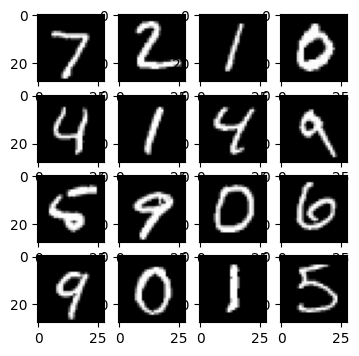

In [6]:
# check loaded data by showing a few images
import matplotlib.pyplot as plt
%matplotlib inline

size = 4
plt.figure(figsize=(size, size))
for i in range(size*size):
  plt.subplot(size, size, i+1)
  plt.imshow(img[i], cmap='gray')

In [7]:
# check loaded data by showing a few labels

print('#label:', lab[:size*size])
print('#one-hot vector:', one[:size*size])

#label: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5]
#one-hot vector: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [8]:
# split the dataset into training and validation datasets
from sklearn.model_selection import train_test_split

img = img.reshape((len(img), -1)) / 256
img_train, img_valid, lab_train, lab_valid, one_train, one_valid = train_test_split(img, lab, one, test_size=0.2, random_state=7)
print('#image:', img_train.shape, img_valid.shape)
print('#label:', lab_train.shape, lab_valid.shape)
print('#one-hot vector:', one_train.shape, one_valid.shape)

#image: (56000, 784) (14000, 784)
#label: (56000,) (14000,)
#one-hot vector: (56000, 10) (14000, 10)


# Lab Requirements

Write the following cells to train and to evaluate a neural network using any Deep Learning APIs.

In [9]:
# prepare the data loaders for training

import random
import torch as pt

dev = random.randint(0, pt.cuda.device_count()-1)
pt.cuda.set_device(dev)
print('#device:', dev)

batchsize = 64
from torch.utils.data import TensorDataset, DataLoader

# add your codes here
img_train = pt.from_numpy(img_train).float().cuda()
img_valid = pt.from_numpy(img_valid).float().cuda()
one_train = pt.from_numpy(one_train).float().cuda()
one_valid = pt.from_numpy(one_valid).int().cuda()
data_train = DataLoader(TensorDataset(img_train, one_train),
                        batch_size=batchsize, shuffle=True, drop_last=True)
data_valid = DataLoader(TensorDataset(img_valid, one_valid),
                        batch_size=batchsize, shuffle=False, drop_last=True)

#device: 2


In [11]:
# implement a simple neural network model using torch.nn
# train the model for 10 epochs using tor  ch.optim
# evaluate the classification accuracy after training each epoch

from tqdm.notebook import tqdm

# add your codes here
import torch.nn as nn
class ConvNetwork(nn.Module):
    def __init__(self,inodes,onodes,lr,hnodes=256) -> None:
        super(ConvNetwork,self).__init__()
        self.lr=lr
        self.ful1=nn.Linear(inodes,hnodes)
        self.ful2=nn.Linear(hnodes,onodes)
        self.module=nn.Sequential(self.ful1,nn.ReLU(),self.ful2)
        self.loss_fun=nn.CrossEntropyLoss() #会自动加上softmax，先softmax，然后log
        self.optim=pt.optim.SGD(self.module.parameters(),lr=self.lr)

    def forward(self,x):
        return self.module(x)
    
    def train_val(self,train_data,val_data,epoch=10):
        for i in range(epoch):
            running_loss = []
            for x, y in tqdm(train_data):
                out=self.forward(x)
                print(out.shape,y.shape)
                loss=self.loss_fun(out,y)
                self.optim.zero_grad()
                loss.backward()
                self.optim.step() #更新参数
                running_loss.append(loss)

            running_acc=[]
            for x,y in val_data:
                out=self.forward(x)
                label=pt.argmax(out,axis=1,keepdim=True)  # 因为第一维是64
                acc=float(pt.sum(label==pt.argmax(y,axis=1,keepdim=True)))/batchsize
                running_acc.append(acc)

            print("epoch: %d\n loss: %.4f \n acc: %.2f%%" 
                  %(i,
                    pt.mean(pt.tensor(running_loss)).detach().numpy(), 
                    pt.mean(pt.tensor(running_acc)).detach().numpy()*100))


learning_rate = 0.1
n=ConvNetwork(784,10,learning_rate).cuda()
n.train_val(data_train,data_valid)

  0%|          | 0/875 [00:00<?, ?it/s]

torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([6

  0%|          | 0/875 [00:00<?, ?it/s]

torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([6

  0%|          | 0/875 [00:00<?, ?it/s]

torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([64, 10])
torch.Size([64, 10]) torch.Size([6

KeyboardInterrupt: 

: 

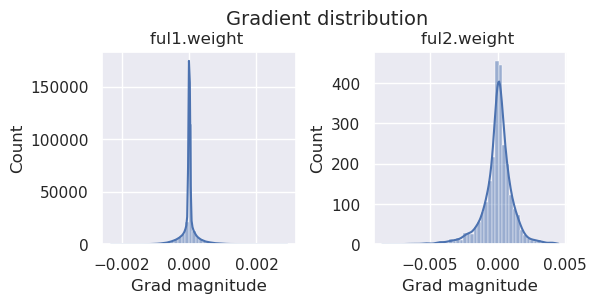

ful1.weight - Variance: 6.959360376868062e-08
ful2.weight - Variance: 1.3184464933146955e-06


In [ ]:
# visualize the training gradients for each layer
import seaborn as sns
sns.set()
import torch.nn.functional as F

def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index%columns]
        sns.histplot(val_dict[key], ax=key_ax, color=color, bins=50, stat=stat,
                     kde=use_kde and ((val_dict[key].max()-val_dict[key].min())>1e-8)) # Only plot kde if there is variance
        key_ax.set_title(f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape)>1 else ""))
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig

def visualize_gradients(model, color="C0", print_variance=False):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    model.eval()
    small_loader = DataLoader(TensorDataset(img_train, one_train),
                        batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(dev), labels.to(dev)

    # Pass one batch through the network, and calculate the gradients for the weights
    model.zero_grad()
    preds = model(imgs)
    loss = F.cross_entropy(preds, labels) # Same as nn.CrossEntropyLoss, but as a function instead of module
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.view(-1).cpu().clone().numpy() for name, params in model.named_parameters() if "weight" in name}
    model.zero_grad()

    ## Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")

visualize_gradients(n,print_variance=True)

In [ ]:
import torch.nn as nn

help(nn.CrossEntropyLoss())

Help on CrossEntropyLoss in module torch.nn.modules.loss object:

class CrossEntropyLoss(_WeightedLoss)
 |  CrossEntropyLoss(weight: Optional[torch.Tensor] = None, size_average=None, ignore_index: int = -100, reduce=None, reduction: str = 'mean', label_smoothing: float = 0.0) -> None
 |  
 |  This criterion computes the cross entropy loss between input logits
 |  and target.
 |  
 |  It is useful when training a classification problem with `C` classes.
 |  If provided, the optional argument :attr:`weight` should be a 1D `Tensor`
 |  assigning weight to each of the classes.
 |  This is particularly useful when you have an unbalanced training set.
 |  
 |  The `input` is expected to contain the unnormalized logits for each class (which do `not` need
 |  to be positive or sum to 1, in general).
 |  `input` has to be a Tensor of size :math:`(C)` for unbatched input,
 |  :math:`(minibatch, C)` or :math:`(minibatch, C, d_1, d_2, ..., d_K)` with :math:`K \geq 1` for the
 |  `K`-dimensional ca